# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA

from loguru import logger

In [23]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
#Verifica os nomes das colunas do dataframe
fifa.columns

Index(['Age', 'Overall', 'Potential', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

In [6]:
#Visualização de quartis, media, desvio padrão e contagem do dataframe
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [7]:
#Apresenta a correlação de todos os dados do dataframe
fifa.corr()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
Age,1.000000,0.452350,-0.253312,0.130545,0.068660,0.147183,0.132894,0.142472,0.010166,0.143276,...,0.139535,0.391023,0.142817,0.119745,0.103089,0.101277,0.106419,0.104964,0.116402,0.103313
Overall,0.452350,1.000000,0.660939,0.394972,0.332515,0.340776,0.502550,0.391338,0.372426,0.419491,...,0.341429,0.727655,0.286505,0.252629,0.222811,-0.025937,-0.025062,-0.029372,-0.017674,-0.023276
Potential,-0.253312,0.660939,1.000000,0.246319,0.243355,0.200988,0.369189,0.254906,0.315019,0.279944,...,0.224281,0.440008,0.162801,0.143564,0.128980,-0.053446,-0.054672,-0.059061,-0.052589,-0.053341
Crossing,0.130545,0.394972,0.246319,1.000000,0.655300,0.469507,0.809660,0.690339,0.856647,0.833105,...,0.645805,0.575446,0.443101,0.428963,0.409961,-0.663053,-0.660193,-0.659767,-0.660160,-0.662539
Finishing,0.068660,0.332515,0.243355,0.655300,1.000000,0.473427,0.661830,0.882675,0.824337,0.759229,...,0.837827,0.533414,0.024218,-0.033023,-0.071811,-0.588752,-0.587145,-0.583268,-0.584852,-0.586913
HeadingAccuracy,0.147183,0.340776,0.200988,0.469507,0.473427,1.000000,0.640091,0.505639,0.550750,0.440846,...,0.551978,0.507208,0.583123,0.561063,0.533643,-0.750417,-0.749888,-0.746444,-0.744443,-0.748895
ShortPassing,0.132894,0.502550,0.369189,0.809660,0.661830,0.640091,1.000000,0.698309,0.843722,0.775398,...,0.676063,0.685137,0.559576,0.541131,0.508644,-0.729785,-0.728024,-0.724381,-0.723782,-0.728721
Volleys,0.142472,0.391338,0.254906,0.690339,0.882675,0.505639,0.698309,1.000000,0.809639,0.807285,...,0.829257,0.595281,0.120919,0.072788,0.035457,-0.590808,-0.588668,-0.584954,-0.586131,-0.588670
Dribbling,0.010166,0.372426,0.315019,0.856647,0.824337,0.550750,0.843722,0.809639,1.000000,0.842652,...,0.769594,0.597498,0.336072,0.301251,0.273963,-0.754625,-0.753181,-0.749816,-0.751348,-0.754341
Curve,0.143276,0.419491,0.279944,0.833105,0.759229,0.440846,0.775398,0.807285,0.842652,1.000000,...,0.751833,0.616532,0.289529,0.261481,0.232869,-0.606286,-0.603141,-0.600266,-0.603540,-0.604960


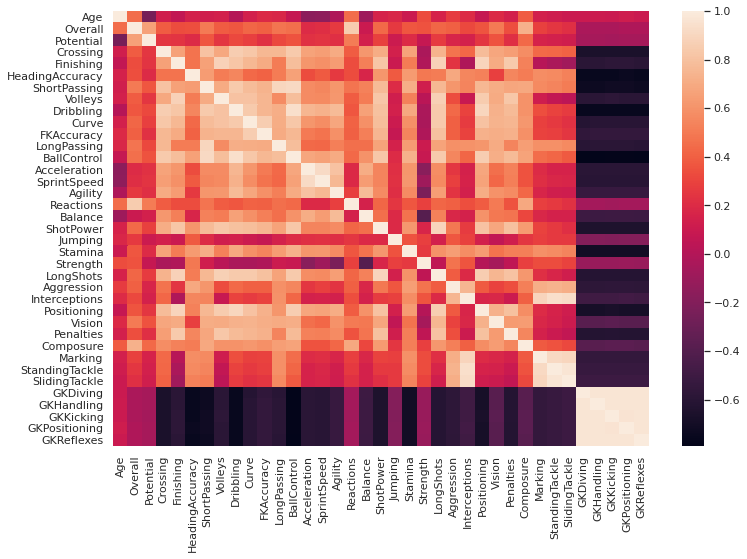

In [8]:
#Mostra graficamente a correlação no dataframe
sns.heatmap(fifa.corr().round(2), fmt = '.3f')
plt.show()

In [9]:
#Apresenta o número de linhas e o número de colunas do dataframe
fifa.shape

(18207, 37)

In [10]:
#Criação de um novo dataframe com as principais informações do dataframe original
df_fifa_aux = pd.DataFrame({'colunas':fifa.columns, 'tipo' : fifa.dtypes,'tamanho' : fifa.shape[0], 'unicos' : fifa.nunique(), 'ausentes' : fifa.isna().sum()})
df_fifa_aux['percentual_ausentes'] = round(df_fifa_aux['ausentes'] / df_fifa_aux['tamanho'], 6)
df_fifa_aux

,colunas,tipo,tamanho,unicos,ausentes,percentual_ausentes
Age,Age,int64,18207,29,0,0.000000
Overall,Overall,int64,18207,48,0,0.000000
Potential,Potential,int64,18207,47,0,0.000000
Crossing,Crossing,float64,18207,89,48,0.002636
Finishing,Finishing,float64,18207,93,48,0.002636
HeadingAccuracy,HeadingAccuracy,float64,18207,91,48,0.002636
ShortPassing,ShortPassing,float64,18207,85,48,0.002636
Volleys,Volleys,float64,18207,87,48,0.002636
Dribbling,Dribbling,float64,18207,94,48,0.002636
Curve,Curve,float64,18207,89,48,0.002636


In [11]:
#Cria novo dataset sem os valores faltantes de fifa
fifa_less_nan = fifa.dropna()

In [12]:
#Mostra linhas e colunas dos datasets com e sem valores ausentes
print(f"Linhas x colunas do dataset original: {fifa.shape}\nLinhas x colunas do dataset sem valores ausentes: {fifa_less_nan.shape}")

Linhas x colunas do dataset original: (18207, 37)
Linhas x colunas do dataset sem valores ausentes: (18159, 37)


In [13]:
#Verifica PCA dos primeiros dois componentes do dataset sem valores nulos
pca = PCA(n_components=2)
first_comp = pca.fit_transform(fifa_less_nan)
first_comp

array([[-126.71792515, -105.58000764],
       [-123.36568604,  -88.98416141],
       [-115.11013638,  -94.77505594],
       ...,
       [  49.83476757,  -44.19006161],
       [  42.8077879 ,  -39.12437286],
       [  37.17937197,   15.60717604]])

In [14]:
#Verifica a porcentagem que o primeiro e segundo componentes explicam
var_expl_first_comp = pca.explained_variance_ratio_
var_expl_first_comp

array([0.56528056, 0.18102522])

In [15]:
#Mostra o número de linhas e variáveis de cada set
print(f'Set original: {fifa_less_nan.shape}, Set PCA: {first_comp.shape}')

Set original: (18159, 37), Set PCA: (18159, 2)


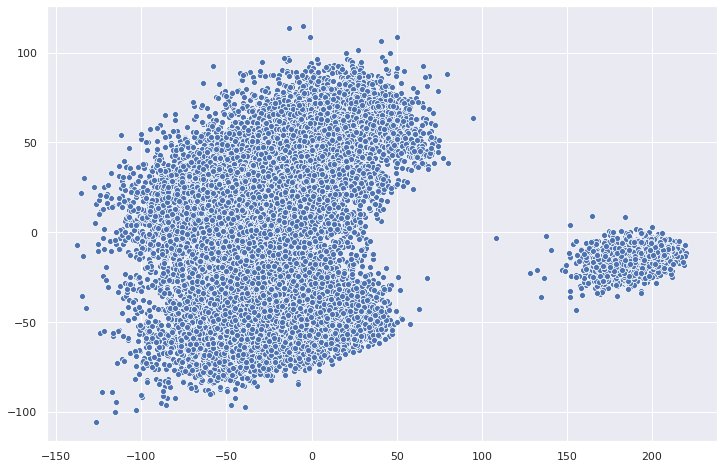

In [16]:
#Vizualização do pca aplicado nos dataset
sns.scatterplot(first_comp[ : , 0] , first_comp[ : , 1])
plt.show()

In [17]:
#Aplica o pca no dataset sem valores ausentes por inteiro
pca_less_nan = PCA().fit(fifa_less_nan)
var_expl = pca_less_nan.explained_variance_ratio_
var_expl

array([5.65280555e-01, 1.81025219e-01, 5.95283391e-02, 4.34269284e-02,
       2.63532326e-02, 1.20707695e-02, 1.03550495e-02, 8.52951131e-03,
       7.87862979e-03, 7.20416677e-03, 7.18180297e-03, 6.32893542e-03,
       5.19242286e-03, 4.90798293e-03, 4.74209042e-03, 4.62772008e-03,
       4.25173246e-03, 3.86288432e-03, 3.76588448e-03, 3.75092615e-03,
       3.47815213e-03, 3.26730709e-03, 3.03137944e-03, 2.97415845e-03,
       2.56797543e-03, 2.30353342e-03, 2.14815132e-03, 1.56135904e-03,
       1.55351696e-03, 1.08664227e-03, 1.06824189e-03, 1.05891525e-03,
       9.58143746e-04, 8.89209394e-04, 8.59732430e-04, 7.34611045e-04,
       1.94187517e-04])

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [18]:
def q1():
    #Escolhe do número de componentes para a PCA
    pca = PCA(n_components=2)
    #Treino dos componentes principais
    pca.fit_transform(fifa_less_nan)
    #Cálculo da porcentagem que o primeiro componente principal consegue explicar
    var_expl_first_comp = pca.explained_variance_ratio_
    return float(var_expl_first_comp[0].round(3))
q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [19]:
def q2():
    #Determinação da porcentagem de variância
    pca_095 = PCA(n_components=0.95)
    #PCA para o número de variância correspondente a 95%
    comps = pca_095.fit_transform(fifa_less_nan)    
    return comps.shape[1]

q2()

15

## Questão 3

Quais são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [20]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [21]:
def q3():
    #Determina o número de componentes para o treino algorítmico
    pca_q3 = PCA(n_components=2)
    #Treina o dataset principal
    pca_q3.fit(fifa_less_nan)
    #Determina as coordenadas de x dentro do dataset treinado
    q3_first_second_comp = pca_q3.components_.dot(x)
    return tuple(q3_first_second_comp.round(3))
q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [22]:
def q4():
    #Importação das bibliotecas necessárias
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LinearRegression
    #Definição das variáveis de treinamento
    X = fifa_less_nan.drop(['Overall'], axis=1)
    y = fifa_less_nan['Overall']
    #Treino de 5 em 5 variáveis
    vars_q4 = RFE(estimator = LinearRegression(), n_features_to_select = 5).fit(X, y)
    return list(X.columns[vars_q4.support_])
q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']